GPU PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU') configured for memory growth
Found 1250 validated image filenames belonging to 2 classes.
Found 745 validated image filenames belonging to 2 classes.
Epoch 1/20
79/79 [==============================] - 69s 797ms/step - loss: 0.5953 - accuracy: 0.7056 - val_loss: 0.5764 - val_accuracy: 0.6577
Epoch 2/20
79/79 [==============================] - 50s 639ms/step - loss: 0.5312 - accuracy: 0.7568 - val_loss: 0.5980 - val_accuracy: 0.6631
Epoch 3/20
79/79 [==============================] - 54s 682ms/step - loss: 0.5373 - accuracy: 0.7640 - val_loss: 0.4708 - val_accuracy: 0.8040
Epoch 4/20
79/79 [==============================] - 52s 661ms/step - loss: 0.5815 - accuracy: 0.7168 - val_loss: 0.5797 - val_accuracy: 0.6577
Epoch 5/20
79/79 [==============================] - 51s 652ms/step - loss: 0.5059 - accuracy: 0.7728 - val_loss: 0.4656 - val_accuracy: 0.7893
Epoch 6/20
79/79 [==============================] - 51s 650ms/step

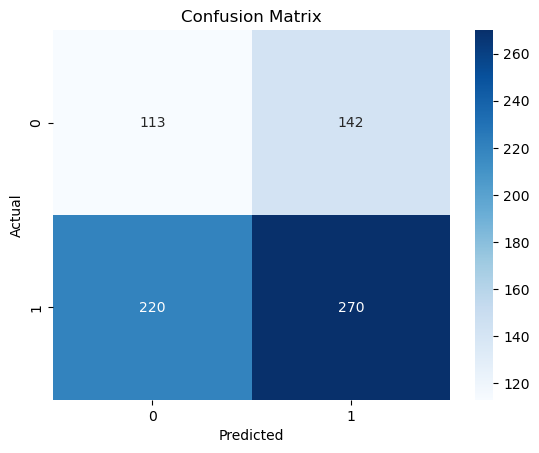

              precision    recall  f1-score   support

      Benign       0.34      0.44      0.38       255
   Malignant       0.66      0.55      0.60       490

    accuracy                           0.51       745
   macro avg       0.50      0.50      0.49       745
weighted avg       0.55      0.51      0.53       745

47/47 [==============================] - 18s 389ms/step


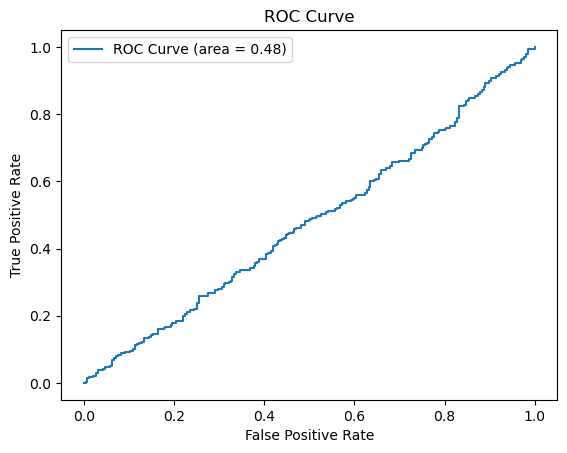

In [3]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import itertools
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image

# Enable GPU acceleration for RTX 4060 Mobile
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    for gpu in gpu_devices:
        tf.config.experimental.set_memory_growth(gpu, True)
        print(f"GPU {gpu} configured for memory growth")

# Directories for train and test data
train_dir = r"D:\01 STUDY MATERIAL\ai project\mkfold\combined fold 1\train_40x"
test_dir = r"D:\01 STUDY MATERIAL\ai project\mkfold\combined fold 1\test_40x"
img_size = (128, 128)
batch_size = 16  # Optimized for GPU memory

# Extract class from filename
def extract_class(filename):
    return "benign" if "SOB_B" in filename else "malignant"

# Create dataframe for images
def create_dataframe(directory):
    filepaths = []
    labels = []
    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith(('png', 'jpg', 'jpeg')):
                filepaths.append(os.path.join(root, file))
                labels.append(extract_class(file))
    return pd.DataFrame({'filename': filepaths, 'class': labels})

train_df = create_dataframe(train_dir)
test_df = create_dataframe(test_dir)

# Data Augmentation and Loading
datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=15,  # Reduced to prevent over-distortion
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def data_generator(df):
    return datagen.flow_from_dataframe(
        df,
        x_col='filename',
        y_col='class',
        target_size=img_size,
        batch_size=batch_size,
        class_mode='binary'
    )

train_data = data_generator(train_df)
test_data = data_generator(test_df)

# Build Conv2D Model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),  # Additional layer for better feature extraction
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, activation='relu'),  # Reduced neurons to prevent overfitting
    tf.keras.layers.Dropout(0.4),  # Added dropout to improve generalization
    tf.keras.layers.Dense(1, activation='sigmoid')
])

# Compile Model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),  # Adjusted for GPU efficiency
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train Model with GPU acceleration
history = model.fit(train_data, validation_data=test_data, epochs=20)  # Increased epochs to use GPU effectively

# Evaluate Model
y_true = test_data.classes
y_pred = (model.predict(test_data) > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_true, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=['Benign', 'Malignant']))

# ROC Curve
y_prob = model.predict(test_data).ravel()
fpr, tpr, _ = roc_curve(y_true, y_prob)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'ROC Curve (area = {roc_auc:.2f})')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Save Model
model.save("cnn_40x.h5")